In [1]:
# import the necessary packages
import config
from dataset import SegmentationDataset
from model import UNet
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import time
import os

In [2]:
# Import CrossEntropyLoss for 3 class classification problem
from torch.nn import CrossEntropyLoss

In [4]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
	test_size=config.TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [5]:
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((config.INPUT_IMAGE_HEIGHT,
		config.INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

[INFO] found 6273 examples in the training set...
[INFO] found 1108 examples in the test set...


In [6]:
# initialize our UNet model
unet = UNet().to(config.DEVICE)
# initialize loss function and optimizer
lossFunc = CrossEntropyLoss()
opt = Adam(unet.parameters(), lr=config.INIT_LR)
# calculate steps per epoch for training and test set: divide length / batch_size
trainSteps = len(trainDS) // config.BATCH_SIZE
testSteps = len(testDS) // config.BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [ ]:
for i in range(len(trainLoader)):
    try:
        images, masks = next(iter(trainLoader))

    except Exception as e:
        print(f"Error encountered at batch index: {i}")
        print(f"Error details: {e}")
        # Optionally, break the loop or handle the error as needed
        break


In [7]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  0%|                                                    | 0/40 [00:00<?, ?it/s]Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
  2%|█                                        | 1/40 [04:06<2:40:09, 246.40s/it]

[INFO] EPOCH: 1/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
  5%|██                                       | 2/40 [08:15<2:36:56, 247.79s/it]

[INFO] EPOCH: 2/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
  8%|███                                      | 3/40 [12:26<2:33:54, 249.59s/it]

[INFO] EPOCH: 3/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
 10%|████                                     | 4/40 [16:41<2:30:49, 251.39s/it]

[INFO] EPOCH: 4/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
 12%|█████▏                                   | 5/40 [20:47<2:25:39, 249.71s/it]

[INFO] EPOCH: 5/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 15%|██████▏                                  | 6/40 [24:54<2:20:54, 248.65s/it]

[INFO] EPOCH: 6/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
 18%|███████▏                                 | 7/40 [29:01<2:16:23, 248.00s/it]

[INFO] EPOCH: 7/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
 20%|████████▏                                | 8/40 [33:07<2:12:03, 247.61s/it]

[INFO] EPOCH: 8/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 22%|█████████▏                               | 9/40 [37:15<2:07:55, 247.58s/it]

[INFO] EPOCH: 9/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
 25%|██████████                              | 10/40 [41:23<2:03:54, 247.83s/it]

[INFO] EPOCH: 10/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 28%|███████████                             | 11/40 [45:31<1:59:44, 247.74s/it]

[INFO] EPOCH: 11/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 30%|████████████                            | 12/40 [49:38<1:55:33, 247.64s/it]

[INFO] EPOCH: 12/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 32%|█████████████                           | 13/40 [53:46<1:51:28, 247.73s/it]

[INFO] EPOCH: 13/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 35%|██████████████                          | 14/40 [57:54<1:47:19, 247.66s/it]

[INFO] EPOCH: 14/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 38%|██████████████▎                       | 15/40 [1:02:01<1:43:13, 247.72s/it]

[INFO] EPOCH: 15/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 40%|███████████████▏                      | 16/40 [1:06:09<1:39:04, 247.70s/it]

[INFO] EPOCH: 16/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 42%|████████████████▏                     | 17/40 [1:10:17<1:34:56, 247.67s/it]

[INFO] EPOCH: 17/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
 45%|█████████████████                     | 18/40 [1:14:24<1:30:48, 247.66s/it]

[INFO] EPOCH: 18/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
 48%|██████████████████                    | 19/40 [1:18:32<1:26:39, 247.60s/it]

[INFO] EPOCH: 19/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 50%|███████████████████                   | 20/40 [1:22:40<1:22:32, 247.64s/it]

[INFO] EPOCH: 20/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 52%|███████████████████▉                  | 21/40 [1:26:47<1:18:25, 247.66s/it]

[INFO] EPOCH: 21/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 55%|████████████████████▉                 | 22/40 [1:30:56<1:14:24, 248.01s/it]

[INFO] EPOCH: 22/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 57%|█████████████████████▊                | 23/40 [1:35:04<1:10:13, 247.86s/it]

[INFO] EPOCH: 23/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 60%|██████████████████████▊               | 24/40 [1:39:11<1:06:05, 247.86s/it]

[INFO] EPOCH: 24/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 62%|███████████████████████▊              | 25/40 [1:43:21<1:02:03, 248.23s/it]

[INFO] EPOCH: 25/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 65%|██████████████████████████              | 26/40 [1:47:28<57:52, 248.01s/it]

[INFO] EPOCH: 26/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
 68%|███████████████████████████             | 27/40 [1:51:36<53:42, 247.87s/it]

[INFO] EPOCH: 27/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 70%|████████████████████████████            | 28/40 [1:55:43<49:33, 247.82s/it]

[INFO] EPOCH: 28/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 72%|█████████████████████████████           | 29/40 [1:59:51<45:25, 247.81s/it]

[INFO] EPOCH: 29/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 75%|██████████████████████████████          | 30/40 [2:03:59<41:19, 247.95s/it]

[INFO] EPOCH: 30/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 78%|███████████████████████████████         | 31/40 [2:08:07<37:10, 247.87s/it]

[INFO] EPOCH: 31/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 80%|████████████████████████████████        | 32/40 [2:12:16<33:06, 248.26s/it]

[INFO] EPOCH: 32/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
 82%|█████████████████████████████████       | 33/40 [2:16:23<28:54, 247.83s/it]

[INFO] EPOCH: 33/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
 85%|██████████████████████████████████      | 34/40 [2:20:30<24:45, 247.57s/it]

[INFO] EPOCH: 34/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
 88%|███████████████████████████████████     | 35/40 [2:24:38<20:37, 247.56s/it]

[INFO] EPOCH: 35/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 90%|████████████████████████████████████    | 36/40 [2:28:45<16:30, 247.58s/it]

[INFO] EPOCH: 36/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
 92%|█████████████████████████████████████   | 37/40 [2:32:53<12:22, 247.65s/it]

[INFO] EPOCH: 37/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
 95%|██████████████████████████████████████  | 38/40 [2:37:01<08:15, 247.73s/it]

[INFO] EPOCH: 38/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
 98%|███████████████████████████████████████ | 39/40 [2:41:11<04:08, 248.37s/it]

[INFO] EPOCH: 39/40
Train loss: 0.000000, Test loss: 0.0000


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
100%|████████████████████████████████████████| 40/40 [2:45:19<00:00, 247.98s/it]

[INFO] EPOCH: 40/40
Train loss: 0.000000, Test loss: 0.0000
[INFO] total time taken to train the model: 9919.12s


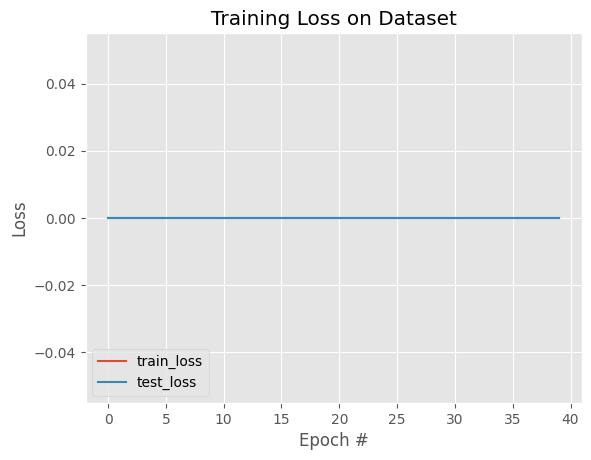

In [8]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)
# serialize the model to disk
torch.save(unet, config.MODEL_PATH)